## Import Libraries

In [1]:
# basic libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
import os 

# model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# other
import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [2]:
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to read image at {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

def load_label(label_path):
    with open(label_path, 'r') as f:
        label = f.read().strip().split()
    return [float(x) for x in label]

def load_dataset(image_dir, label_dir, target_size=(128, 128)):
    images = []
    labels = []
    for dtype in ['train', 'val']:
        img_type_dir = os.path.join(image_dir, dtype)
        label_type_dir = os.path.join(label_dir, dtype)
        for img_name in os.listdir(img_type_dir):
            img_path = os.path.join(img_type_dir, img_name)
            label_path = os.path.join(label_type_dir, img_name.replace('.jpg', '.txt'))
            if os.path.exists(label_path):
                image = load_and_preprocess_image(img_path, target_size)
                if image is not None:
                    label = load_label(label_path)
                    images.append(image)
                    labels.append(label)
    return np.array(images), labels  # Ubah hanya images menjadi np.array

# Muat dataset
image_dir = r'D:\DS_ML_Project\Face-Detection-\dataset\images'
label_dir = r'D:\DS_ML_Project\Face-Detection-\dataset\labels'
images, labels = load_dataset(image_dir, label_dir)

# Konversi labels menjadi numpy array dengan padding
max_label_length = max(len(label) for label in labels)
padded_labels = np.zeros((len(labels), max_label_length))
for i, label in enumerate(labels):
    padded_labels[i, :len(label)] = label

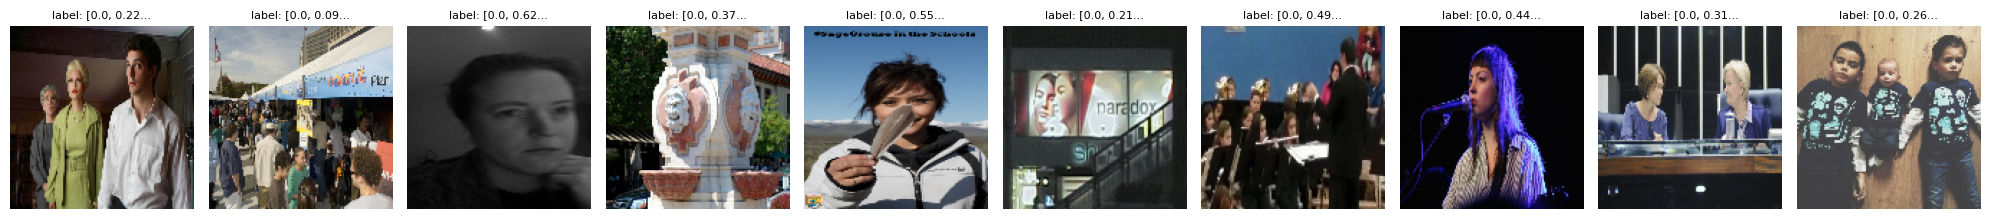

In [3]:
def display_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20,4))
    for i in range(num_images):
        # Langsung menggunakan imshow tanpa konversi warna
        axes[i].imshow(images[i])
        # Memotong label menjadi 10 karakter pertama
        short_label = str(labels[i])[:10] + "..." if len(str(labels[i])) > 10 else str(labels[i])
        axes[i].set_title(f"label: {short_label}", fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

display_images(images, labels)

## Modelling

In [4]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, padded_labels, test_size=0.2, random_state=42)

# Definisikan model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(max_label_length)  # Sesuaikan dengan panjang label maksimum
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

early_stoppping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

In [5]:
#  train model
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - loss: 0.0171 - mae: 0.0512 - val_loss: 0.0073 - val_mae: 0.0218
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - loss: 0.0068 - mae: 0.0224 - val_loss: 0.0065 - val_mae: 0.0299
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.0063 - mae: 0.0266 - val_loss: 0.0053 - val_mae: 0.0243
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - loss: 0.0050 - mae: 0.0238 - val_loss: 0.0050 - val_mae: 0.0246
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - loss: 0.0044 - mae: 0.0234 - val_loss: 0.0050 - val_mae: 0.0245
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - loss: 0.0050 - mae: 0.0254 - val_loss: 0.0050 - val_mae: 0.0253
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - loss: 0.0043 - mae: 0.0238 - val_loss: 0.0052 - val_mae: 0.0237
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - loss: 0.0038 - mae: 0.0232 - val_loss: 0.0051 - val_mae: 0.0259
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - loss: 0.0038 - mae:

## Model Evaluation

Test MAE: 0.02465389482676983


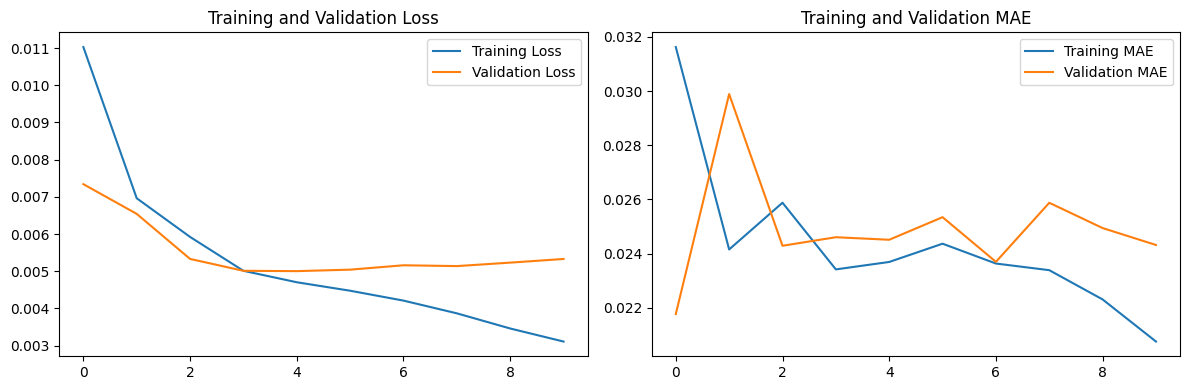

In [6]:
# Evaluasi model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

# Visualisasi hasil training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

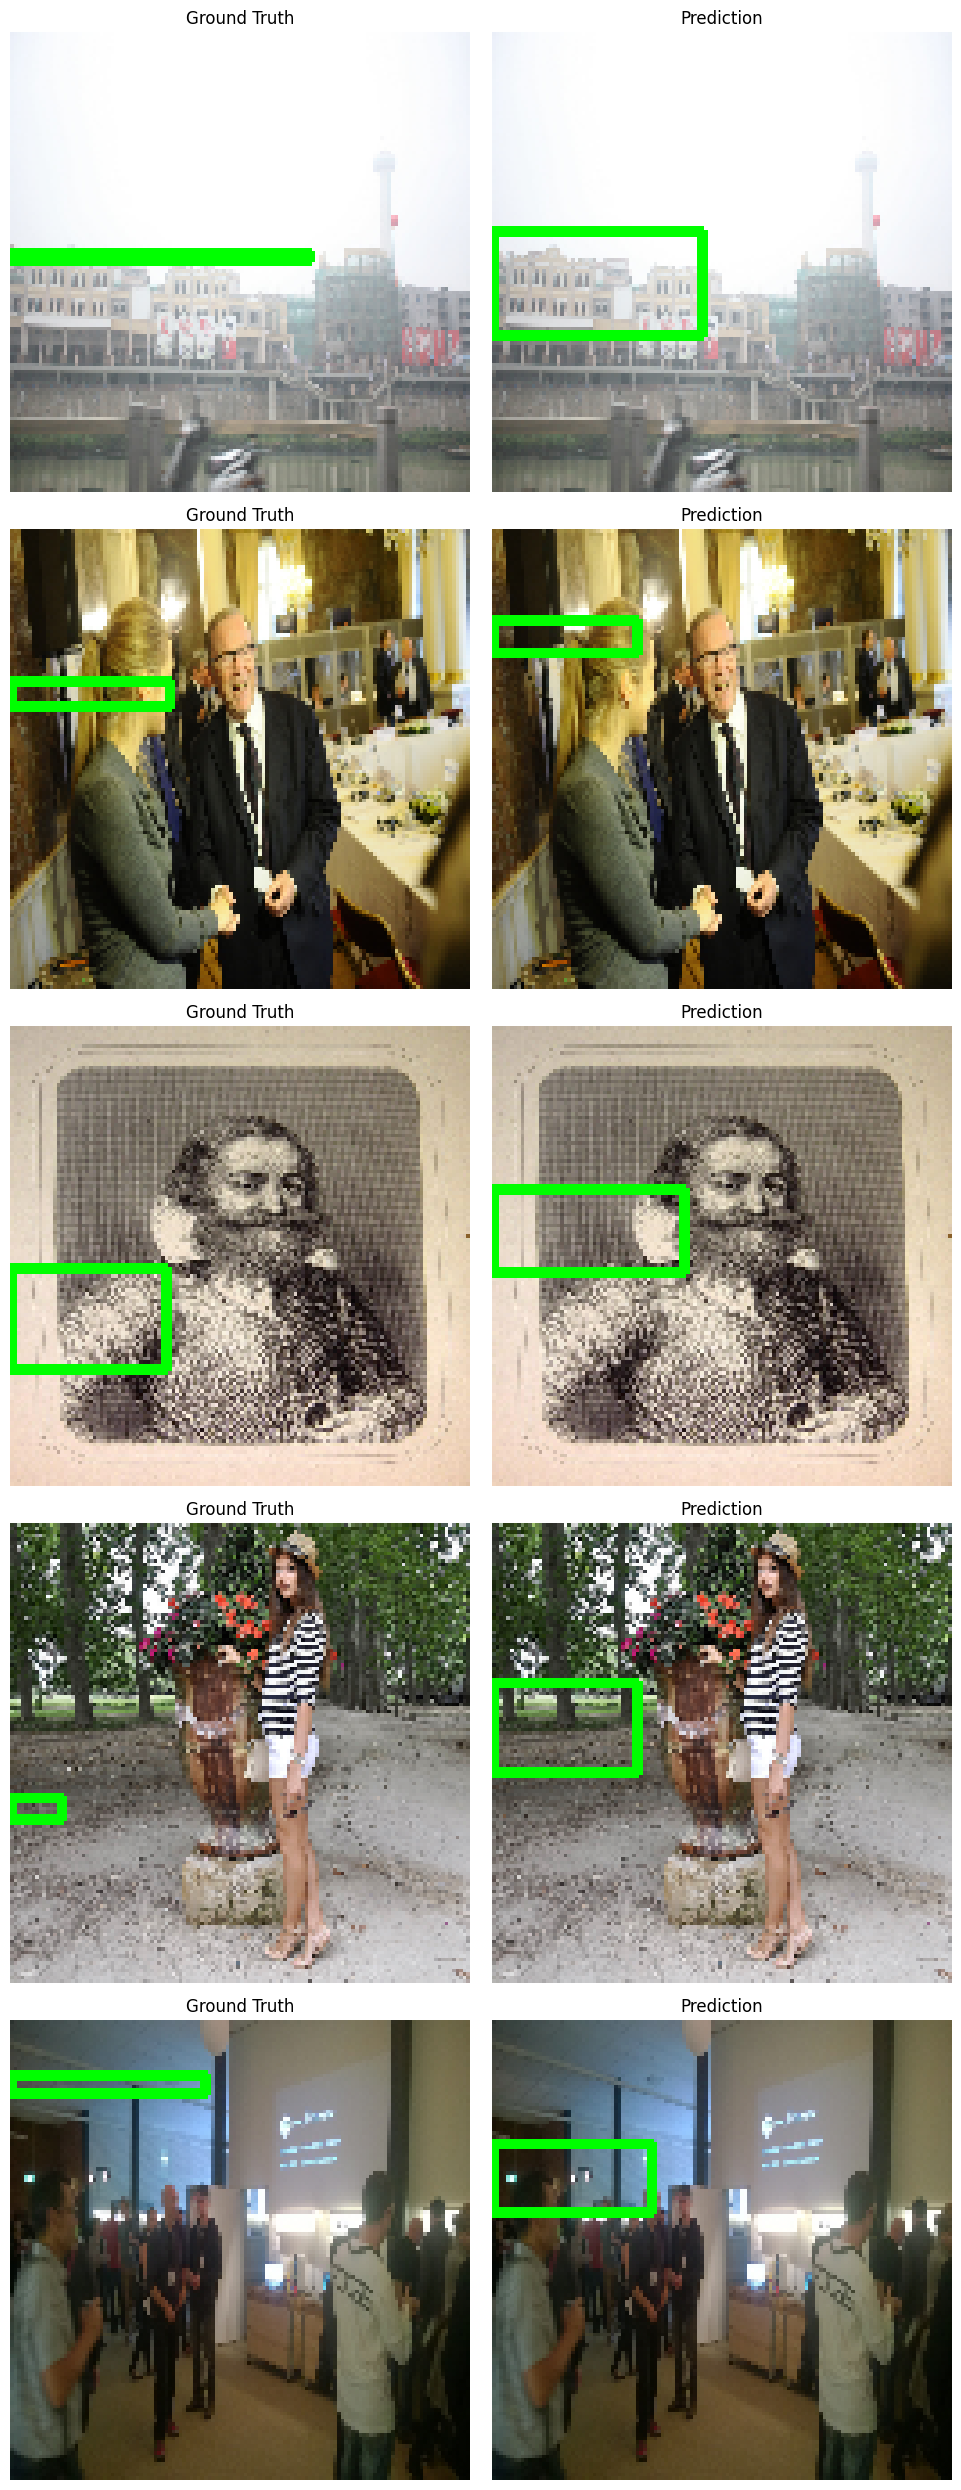

In [7]:
# Fungsi untuk menggambar bounding box
def draw_bounding_box(image, bbox):
    x, y, w, h = bbox[:4]  # Ambil 4 nilai pertama saja
    x, y, w, h = int(x * image.shape[1]), int(y * image.shape[0]), int(w * image.shape[1]), int(h * image.shape[0])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return image

# Visualisasi hasil prediksi
def visualize_predictions(model, X_test, y_test, num_images=5):
    predictions = model.predict(X_test[:num_images])
    
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5*num_images))
    for i in range(num_images):
        # Gambar asli dengan bounding box sebenarnya
        img_true = X_test[i].copy()
        img_true = draw_bounding_box(img_true, y_test[i])
        axes[i, 0].imshow(img_true)
        axes[i, 0].set_title('Ground Truth')
        axes[i, 0].axis('off')
        
        # Gambar dengan bounding box prediksi
        img_pred = X_test[i].copy()
        img_pred = draw_bounding_box(img_pred, predictions[i])
        axes[i, 1].imshow(img_pred)
        axes[i, 1].set_title('Prediction')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualisasi beberapa hasil prediksi
visualize_predictions(model, X_test, y_test)